In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import math
import numpy as np

import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
### function to plot trajectory ###

def rotate(x, y, angle):
    return [x * np.cos(np.radians(angle)) - y * np.sin(np.radians(angle)), 
            x * np.sin(np.radians(angle)) + y * np.cos(np.radians(angle))]


def generate_road(road_fn, n_samples, domain, eps=0):
    start_x, end_x = domain
    x = np.linspace(start_x, end_x, n_samples)
    return [(i - eps, road_fn(i)) for i in x]


def plot_trajectory(states, road, verbose=False):

    plt.figure(figsize=(20, 5))
    plt.plot(*zip(*road), color='gold', linestyle='--')

    road = np.array(road)

    colors = cm.rainbow(np.linspace(0, 1, len(states)))
    for i, state in enumerate(states):
        x, y, velocity, heading = state
        heading = heading % 360 
        if verbose:
            print(f"x: {x}, y: {y}, velocity: {velocity}, heading: {heading}")
            print(f"centerline error: {shortestDistanceToPolylineNumpy(np.array([x, y]), road)}")
        plt.plot(x, y, marker=(3, 0, heading - 90), markersize=5, color=colors[i])
    print('\n' * 2)
    plt.show()

In [3]:
road1_formula = lambda x: 2 * x + 0
road1 = generate_road(road1_formula, 500, (-30, 30))

road2_formula = lambda x: 10 * math.log(x + 30) - 30
road2 = generate_road(road2_formula, 500, (-20, 100), eps=.5)

# plt.figure(figsize=(20, 5))
# plt.plot(*zip(*road2), color='gold', linestyle='--')

[44.658947009635355, 43.98630889772819, 43.3296450422534, 42.688559471261854, 42.06265917706482, 41.45155505392088, 40.85486271042127, 40.27220316734884, 39.70320345129795, 39.147497093775094, 38.6047245448908, 38.07453351021406, 37.556579218707, 37.05052462908195, 36.55604058137867, 36.0728058999542, 35.600507453604564, 35.13884017797886, 34.68750706502658, 34.246219123750286, 33.814695316125196, 33.39266247166238, 32.97985518377781, 32.57601569072825, 32.18089374366742, 31.794246464040945, 31.415838192308122, 31.045440329764666, 30.68283117502683, 30.327795756548866, 29.980125662381884, 29.639618868242998, 29.3060795647981, 28.979317984987297, 28.659150232060544, 28.345398108930222, 28.037888949352013, 27.73645545135423, 27.440935513302165, 27.151172072854582, 26.86701294911909, 26.5883106881533, 26.314922411998957, 26.04670967136688, 25.78353830205053, 25.525278285145802, 25.271803611091716, 25.022992147569372, 24.77872551124205, 24.538888943316124, 24.303371188899906, 24.0720643801

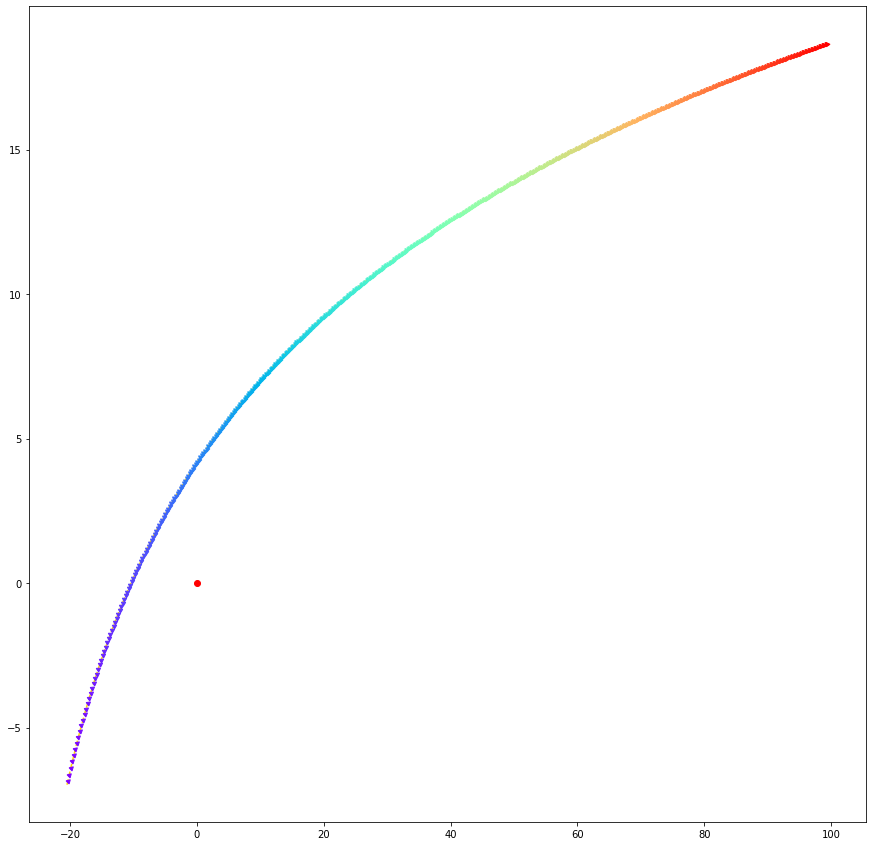

In [11]:
# def shortestDistanceToPolyline(pt, centerLinePts, discretization=1):

#     distance = float('inf')
#     tangentLine = None 
#     for i in range(discretization, len(centerLinePts), discretization):
#         ptA, ptB = centerLinePts[i - discretization], centerLinePts[i]

#         centerLine, ptShift = ptB - ptA, pt - ptA

#         projection = (centerLine[0] * ptShift[0] + centerLine[1] * ptShift[1]) / np.linalg.norm(centerLine, ord=2) ** 2
#         projection = projection * centerLine

#         # sign = math.copysign(1, pt - projection)

#         rejection_dist = np.sqrt(np.square(pt[0] - projection[0]) + np.square(pt[1] - projection[1]))
#         if rejection_dist < distance:
#             tangentLine = centerLine
#             projectionPt = projection
#             distance = rejection_dist

#     return distance, projectionPt, np.arctan2(tangentLine[1], tangentLine[0])


a = np.array([[0., 0.], [-1.790459, -0.257227], [-5.80854, -0.502159], [-12.0319, -0.40955], [-20.39566, 0.34799],
              [-30.79839, 2.1080], [-43.1017, 5.20846], [-57.1289, 9.97623], [-72.66506, 16.7196], [-89.45834, 25.7220]])

def projections(pt, centerLinePts, discretization=1):

    projectionPts, angles = [], []
    for i in range(discretization, len(centerLinePts), discretization):
        ptA, ptB = centerLinePts[i - discretization], centerLinePts[i]

        centerLine = ptB - ptA
        midPt = (ptA + ptB) / 2
        projection = midPt

        projectionPts.append(projection)
        angles.append(np.degrees(np.arctan2(centerLine[1], centerLine[0])))

    return projectionPts, angles

plt.figure(figsize=(15, 15))
plt.plot(*zip(*road2), color='gold', linestyle='--')

pts, angles = projections(a[0], np.array(road2))

print(angles)

colors = cm.rainbow(np.linspace(0, 1, len(pts)))
for i, pt in enumerate(pts):
    x, y = pt
    plt.plot(x, y, marker=(3, 0, angles[i] - 90), markersize=5, color=colors[i])

plt.plot(a[0][0], a[0][1], 'ro')


# colors = cm.rainbow(np.linspace(0, 1, len(road2)))
# for i, pt in enumerate(road2[:2]):
#     x, y = pt
#     plt.plot(x, y, marker='o', color=colors[i])

# a = np.array([[0., 0.], [2.0, 0.0], [5.34806, -0.03509], [10.01248, -0.13519], [16.09123, -0.340252], [23.67596, -0.68019]])
# b = np.array([[0., 0.], [2.0, 0.0], [5.2152, 0.42528], [9.919742, 1.452747], [16.17708, 3.10022], [24.08562, 5.3594900]])


# colors = cm.rainbow(np.linspace(0, 1, len(a)))

# for i, pt in enumerate(a):
#     x, y = pt
#     plt.plot(x, y, marker='o', markersize=5, color=colors[i])

#     lateralError, projPt, roadHeading = shortestDistanceToPolyline(pt, np.array(road2))
#     x, y = projPt
#     print(lateralError, roadHeading)
#     plt.plot(x, y, marker=(3, 0, roadHeading - 90), markersize=5, color=colors[i])

Input a number of things:

1. k nearest objects to us, with predictions of locations in near future
2. Road-map, center-lines, etc. (polylines as features)
3. Desired waypoint destination (x, y features) given by another larger coarse network

In [35]:
# MODEL

# Recurrent neural network
class PathPlanner(nn.Module):
    def __init__(self, 
                 input_size, 
                 n_features, 
                 hidden_size, 
                 output_size, 
                 num_layers, 
                 road_samples,
                 gpu=0):
        super(PathPlanner, self).__init__()

        self.gpu = gpu

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.road_embed = RoadMapper(road_samples)
        self.features_embed = nn.Linear(n_features, n_features)
    
        self.lstm = nn.LSTM(n_features + road_samples // 4, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        

    def forward(self, x, roadmap):
        batch_size = x.size(0)

        # Set initial hidden and cell states 
        h0 = torch.randn(self.num_layers, batch_size, self.hidden_size, dtype=torch.double)
        c0 = torch.randn(self.num_layers, batch_size, self.hidden_size, dtype=torch.double)
        if self.gpu:
            h0 = h0.cuda()
            c0 = c0.cuda()

        road = self.road_embed(roadmap)
        road = torch.tile(road, (1, self.input_size, 1))

        x = self.features_embed(x)
        x = nn.Tanh()(x)
        
        x = torch.cat((x, road), axis=-1)
            
        # Forward propagate LSTM
        x, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        x = nn.Tanh()(x)
        
        x = self.fc1(x)
        x = torch.unsqueeze(x, axis=-1)
        x = nn.Tanh()(x)

        return x


class RoadMapper(nn.Module):
    def __init__(self, samples):
        super(RoadMapper, self).__init__()
        self.fc1 = nn.Linear(2, 1)
        self.fc2 = nn.Linear(samples, samples // 4)
    
    def forward(self, x):
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = torch.swapaxes(x, -1, -2)

        x = self.fc2(x)
        x = nn.Tanh()(x)

        return x


# consider the objects around vehicle
class EnvironmentEmbedder(nn.Module):
    def __init__(self, samples,  states, controls):
        super(EnvironmentEmbedder, self).__init__()
        self.controller = nn.Sequential(
            nn.Linear(),
            nn.BatchNorm1d(),
        )
        
    
    def forward(self, x):
        z = self.sampler(x)
        return z

In [36]:
from torch.utils.data import Dataset

def buildDataset(n, seq_len, desired_v):
    dataset, initialStates = [], []

    for _ in range(n):
        # x = np.random.normal(0, 10)
        # y = np.random.normal(0, 10)
        # v = abs(np.random.normal(0, 10))
        v = 0.01
        # h = np.random.normal(0, 10)
        h = 270
        x, y = 0, 0

        dataset.append([[x, y, v, h, desired_v]] * seq_len)
        initialStates.append([[x], [y], [v], [h], [desired_v]])
    
    dataset = np.array(dataset)
    initialStates = np.array(initialStates)
    return dataset, initialStates


class ControlsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        return self.data[0][idx], self.data[1][idx]

In [45]:
# state: [[x1, y1, v1, h1], [x2, y2, v2, h2], ...]
# controls: [vx, vy, a, w]
def stateUpdateEqn(state, controls, timeStep):
    controls[0, 0] = state[2, 0] * torch.cos(torch.deg2rad(state[3, 0]))
    controls[1, 0] = state[2, 0] * torch.sin(torch.deg2rad(state[3, 0]))
    return state + timeStep * controls


def shortestDistanceToPolyline(pt, centerLinePts, discretization=5):

    distance = torch.tensor(float('inf'))
    tangentLine = None 
    for i in range(discretization, len(centerLinePts), discretization):
        ptA, ptB = centerLinePts[i - discretization], centerLinePts[i]

        centerLine = ptB - ptA
        midPt = (ptA + ptB) / 2
        projection = midPt
        
        # projection = (centerLine[0] * ptShift[0] + centerLine[1] * ptShift[1]) / torch.norm(centerLine, p=2)
        # projection = projection * centerLine + ptA

        rejection_dist = torch.sqrt(torch.square(pt[0] - projection[0]) + torch.square(pt[1] - projection[1]))
        if rejection_dist < distance:
            tangentLine = centerLine
            distance = rejection_dist

    return distance, torch.atan2(tangentLine[1], tangentLine[0])


def computeHeadingError(realHeading, desiredHeading):
    delta = desiredHeading - torch.deg2rad(realHeading)
    return torch.rad2deg(torch.atan2(torch.sin(delta), torch.cos(delta)))

class CompletePathLoss(nn.Module):

    def __init__(self):
        pass 

    def forward(self):
        pass


class AvoidanceLoss(nn.Module):

    def __init__(self):
        pass

    def forward(self, objects):
        pass


constraints = np.array([[0, 0, 0, 0],
                        [0, 0, 0, 0],
                        [0, 0, 5, 0],
                        [0, 0, 0, 30]])

class PlannerLoss(nn.Module):

    constraints = torch.tensor(constraints, dtype=torch.double)
    
    def __init__(self,
                 costWeights,
                 desiredStates,
                 timeStep=1,
                 gpu=False):
        super(PlannerLoss, self).__init__()

        self.gpu = gpu
        self.timeStep = timeStep
        self.centerLineWeight, self.velocityWeight, self.headingWeight = costWeights

        self.desiredVelocity = desiredStates

        if gpu:
            self.constraints = self.constraints.cuda()
        

    def forward(self, initialState, controls, centerLines, verbose=1):
        totalBatchCost = 0
        batchDim = initialState.size(0)
        
        for i in range(batchDim):
            cost = 0
            state = initialState[i,:-1,...]
            centerLine = centerLines[i,...]
            for j in range(controls.size(1)):
                state = stateUpdateEqn(state, torch.matmul(self.constraints, controls[i,j,...]), self.timeStep)

                stateSqueeze = torch.squeeze(state)
                cartesian, polar = stateSqueeze[:2], stateSqueeze[2:]
                x, y = cartesian; velocity, heading = polar

                lateralError, roadHeading = shortestDistanceToPolyline(cartesian, centerLine)
                headingError = computeHeadingError(heading, roadHeading)
                velocityError = self.desiredVelocity - velocity
                
                if verbose:
                    print(f"state {j+1}:")
                    print(f"x: {x}, y: {y}, velocity: {velocity}, heading: {heading}")
                    print("distance error:", lateralError)
                    print("velocity error:", velocityError)
                    print("heading error:", headingError)

                centerLineWeight = self.centerLineWeight * (controls.size(1) - j)
                headingWeight = self.headingWeight * (controls.size(1) - j)
                velocityWeight = self.velocityWeight * (controls.size(1) - j)

                cost += centerLineWeight * torch.pow(lateralError, 2)
                cost += velocityWeight * torch.pow(velocityError, 2)
                cost += headingWeight * torch.pow(headingError, 2)

            totalBatchCost += cost / controls.size(1)

        return totalBatchCost / batchDim


def shortestDistanceToPolylineNumpy(pt, centerLinePts):

    distance = float('inf')

    for i in range(1, len(centerLinePts)):
        ptA, ptB = centerLinePts[i - 1], centerLinePts[i]
        # see here: http://www.math.lsa.umich.edu/~glarose/classes/calcIII/web/13_5/
        # shift points to origin (offset by ptA)
        ptShift = pt - ptA
        centerLine = ptB - ptA

        projection = (centerLine[0] * ptShift[0] + centerLine[1] * ptShift[1]) / np.linalg.norm(centerLine, ord=2)
        projection = projection * centerLine + ptA

        rejection_dist = np.sqrt(np.square(pt[0] - projection[0]) + np.square(pt[1] - projection[1]))
        distance = np.minimum(rejection_dist, distance)

    return distance


def stateUpdateEqnNumpy(state, controls, timeStep):
    controls[0, 0] = state[2, 0] * np.cos(np.deg2rad(state[3, 0]))
    controls[1, 0] = state[2, 0] * np.sin(np.deg2rad(state[3, 0]))
    return state + timeStep * controls


def getUpdatedStates(initialState, controls, timeStep=1):
    state = initialState[0][:-1]
    states = [state]
    for control in controls[0]:
        state = stateUpdateEqnNumpy(state, constraints @ control, timeStep)
        states.append(state)
    return states

Number of trainable params in model: 297982

inital heading tensor(10., dtype=torch.float64) 

x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.961093156672097
x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.961093156672097
x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.961093156672097
x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.961093156672097
x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.961093156672097
x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.961093156672097
x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.961093156672097
x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.961093156672097
x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.961093156672097
x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.961093156672097
x: 0.0, y: 0.0, velocity: 0.01, heading: 270.0
centerline error: 3.96109315

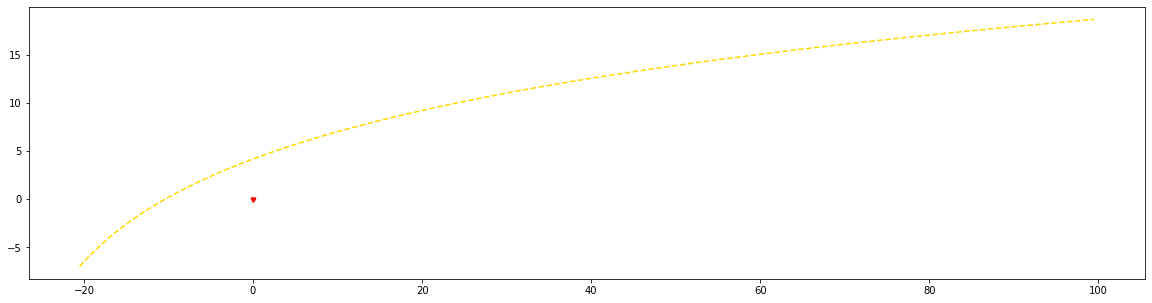




state 1:
x: -1.8369701987210296e-19, y: -0.001, velocity: -0.07736900753767853, heading: 269.3624489521003
distance error: tensor(4.0054, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.0774, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.8891, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: 8.608954155433409e-05, y: 0.006736421773952643, velocity: -0.16224377636771758, heading: 268.96957316315576
distance error: tensor(3.9986, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.1622, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(110.2820, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: 0.00037785855282996986, y: 0.022958175703310553, velocity: -0.23500572040273426, heading: 268.60146000724046
distance error: tensor(3.9844, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.2350, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(

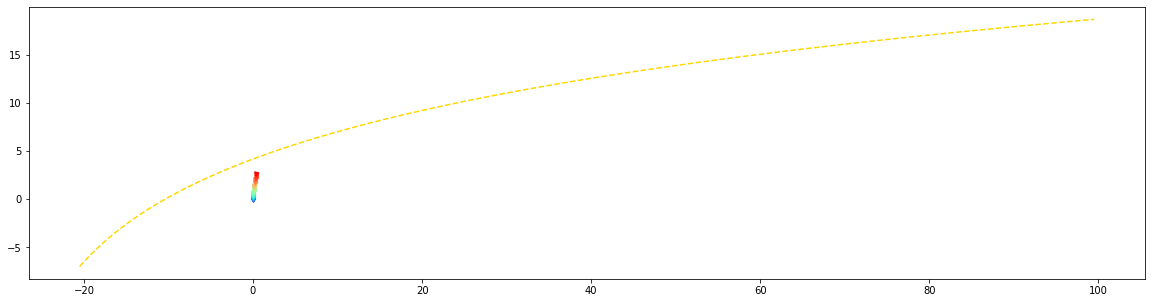


loss = 617080.0132922565


state 1:
x: -1.8369701987210296e-19, y: -0.001, velocity: 0.08135600274252029, heading: 270.2828778497093
distance error: tensor(4.0054, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.9186, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(108.9687, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: 4.016651456199603e-05, y: -0.009135501119999778, velocity: 0.07792974824322327, heading: 270.1084317278977
distance error: tensor(4.0126, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.9221, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.1431, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: 5.491463786958868e-05, y: -0.016928461988975095, velocity: 0.04114431912071829, heading: 269.8155036203551
distance error: tensor(4.0195, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.9589, dtype=torch.float64, grad_fn=<RsubBackward1>)
head

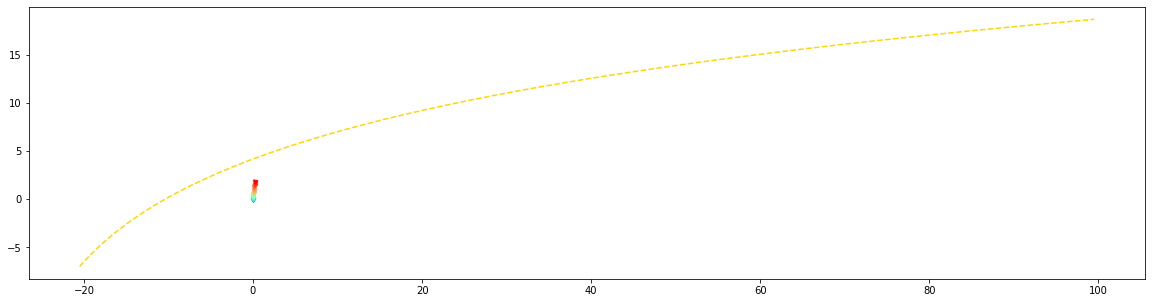


loss = 604949.3397473508


state 1:
x: -1.8369701987210296e-19, y: -0.001, velocity: 0.003978972024257373, heading: 269.7059191110284
distance error: tensor(4.0054, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.9960, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.5457, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -2.042269958217751e-06, y: -0.0013978919612553714, velocity: -0.006097127385935401, heading: 269.3944352206746
distance error: tensor(4.0057, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.0061, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.8571, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: 4.401724506256927e-06, y: -0.0007882132765873108, velocity: -0.03728047328899879, heading: 269.02718239461103
distance error: tensor(4.0052, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.0373, dtype=torch.float64, grad_fn=<RsubBackwa

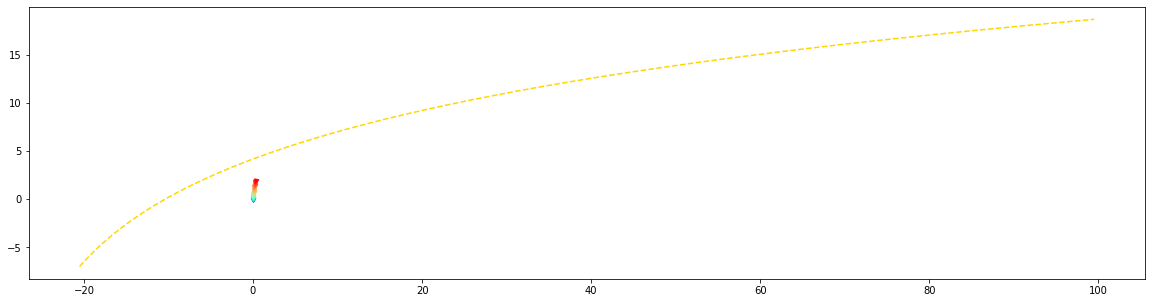


loss = 613502.7122938406


state 1:
x: -1.8369701987210296e-19, y: -0.001, velocity: 0.006823257208926157, heading: 269.61975052066225
distance error: tensor(4.0054, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.9932, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.6318, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -4.52829331809416e-06, y: -0.0016823106945895346, velocity: -0.04237985822659504, heading: 269.30932695855756
distance error: tensor(4.0060, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.0424, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.9423, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: 4.6557348483912295e-05, y: 0.0025553672179310276, velocity: -0.10236087130443171, heading: 269.015617469748
distance error: tensor(4.0023, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.1024, dtype=torch.float64, grad_fn=<RsubBackward

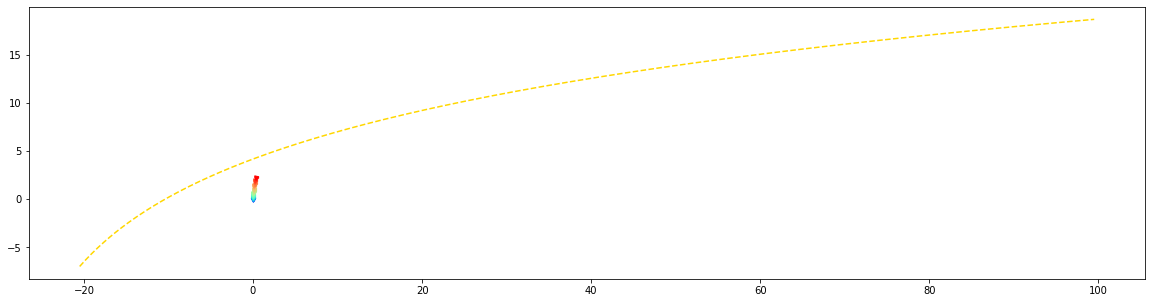


loss = 611642.0006352094


state 1:
x: -1.8369701987210296e-19, y: -0.001, velocity: 0.0026546762172072686, heading: 270.5853939625533
distance error: tensor(4.0054, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.9973, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(108.6662, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: 2.7122493250917287e-06, y: -0.001265453766003908, velocity: -0.018256469400719847, heading: 270.585200284677
distance error: tensor(4.0056, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.0183, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(108.6664, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -1.5933985057444632e-05, y: 0.0005600979499815781, velocity: -0.047242499598161417, heading: 270.3430040078906
distance error: tensor(4.0040, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.0472, dtype=torch.float64, grad_fn=<RsubBackwa

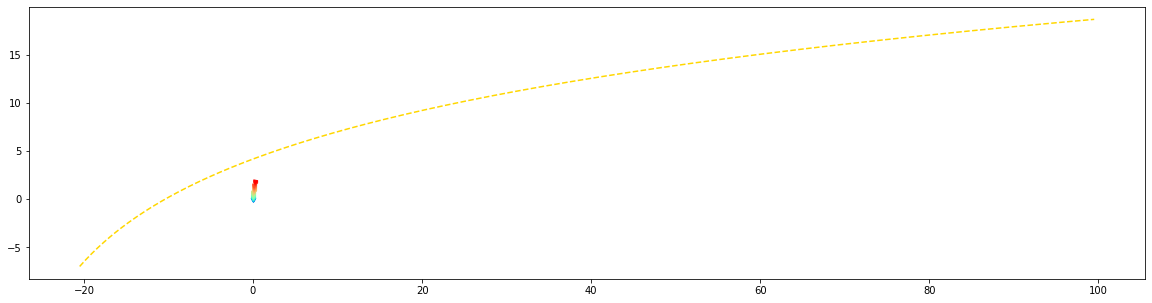


loss = 599290.0642910921


state 1:
x: -1.8369701987210296e-19, y: -0.001, velocity: 0.10536594176373869, heading: 269.734211345803
distance error: tensor(4.0054, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.8946, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.5174, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -4.8877895817495466e-05, y: -0.011536480806649638, velocity: 0.1301538478897553, heading: 269.2738069619229
distance error: tensor(4.0147, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.8698, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.9778, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -0.00021383644683021106, y: -0.024550820201392015, velocity: 0.11446683622350157, heading: 268.78120158112307
distance error: tensor(4.0261, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.8855, dtype=torch.float64, grad_fn=<RsubBackward1>)
h

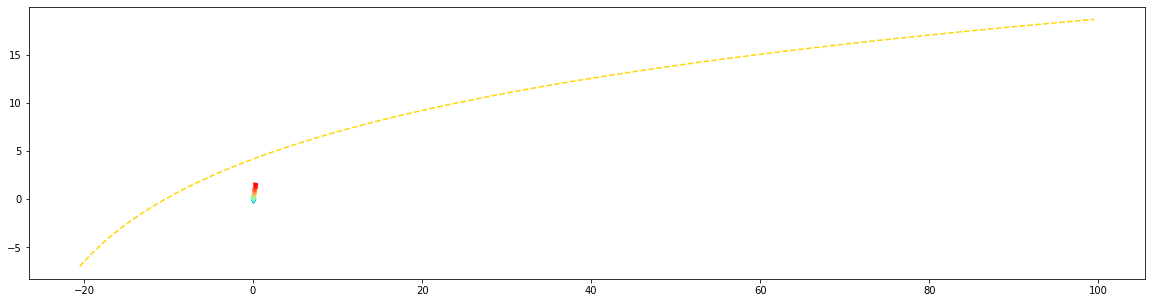


loss = 618424.8339928291


state 1:
x: -1.8369701987210296e-19, y: -0.001, velocity: -0.1079198220588979, heading: 269.44962303387746
distance error: tensor(4.0054, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.1079, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.8020, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: 0.00010366500169265031, y: 0.009791484304750016, velocity: -0.18491355609212673, heading: 269.0078207678692
distance error: tensor(3.9959, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.1849, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(110.2438, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: 0.0004238600009656263, y: 0.028280067469200493, velocity: -0.24721097602361847, heading: 268.56476619529747
distance error: tensor(3.9797, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.2472, dtype=torch.float64, grad_fn=<RsubBackward1>

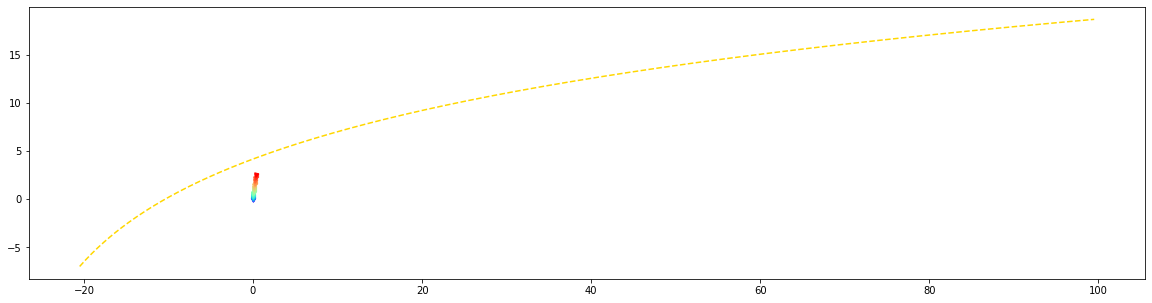


loss = 618621.8923835232


state 1:
x: -1.8369701987210296e-19, y: -0.001, velocity: -0.08170738793667699, heading: 269.8411560835093
distance error: tensor(4.0054, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.0817, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.4104, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: 2.2652113280977205e-05, y: 0.007170707393861941, velocity: -0.16496110350316523, heading: 269.4993896997763
distance error: tensor(3.9982, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.1650, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.7522, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: 0.00016678171155521068, y: 0.02366618808854681, velocity: -0.24588471742292334, heading: 269.117355380551
distance error: tensor(3.9836, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.2459, dtype=torch.float64, grad_fn=<RsubBackward1>)


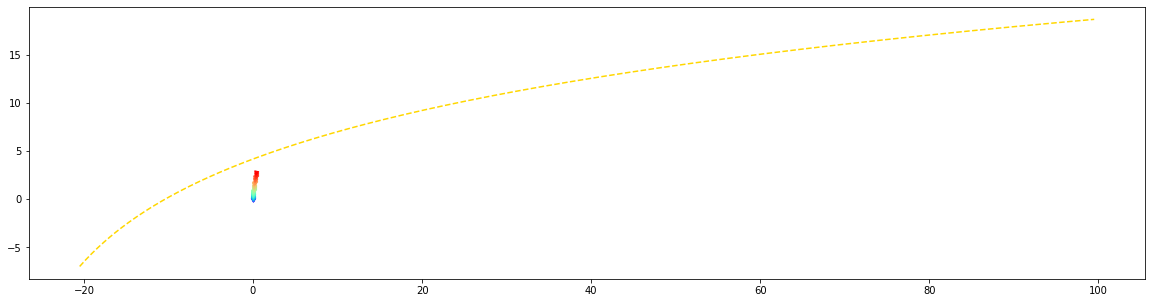


loss = 611547.8018076008


state 1:
x: -1.8369701987210296e-19, y: -0.001, velocity: -0.03528417313854952, heading: 269.46790382988183
distance error: tensor(4.0054, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.0353, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.7837, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: 3.2767341127055836e-05, y: 0.0025282651603963755, velocity: -0.07867282757312284, heading: 269.0746037627537
distance error: tensor(4.0023, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.0787, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(110.1770, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: 0.0001598279623364594, y: 0.01039452180393662, velocity: -0.12824952844243556, heading: 268.6637387108448
distance error: tensor(3.9954, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(10.1282, dtype=torch.float64, grad_fn=<RsubBackward1>

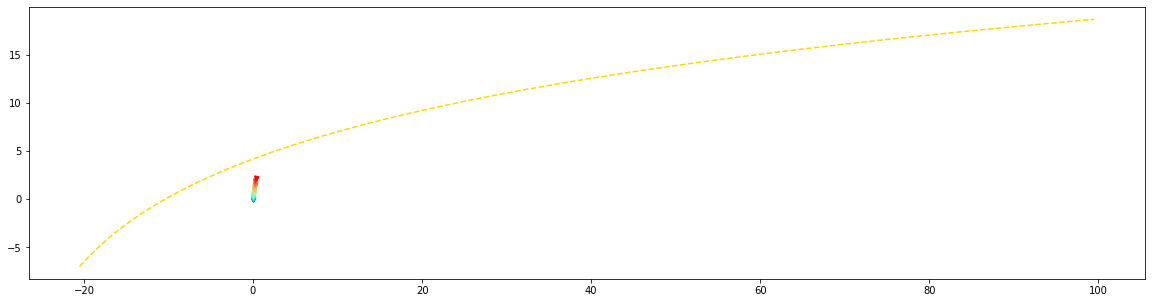


loss = 617665.7004378927


state 1:
x: -1.8369701987210296e-19, y: -0.001, velocity: 0.06341356168846672, heading: 269.75335251536205
distance error: tensor(4.0054, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.9366, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.4982, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 2:
x: -2.7298253567247106e-05, y: -0.007341297411848929, velocity: 0.07918824624001712, heading: 269.509843962345
distance error: tensor(4.0110, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.9208, dtype=torch.float64, grad_fn=<RsubBackward1>)
heading error: tensor(109.7417, dtype=torch.float64, grad_fn=<Rad2DegBackward0>)
state 3:
x: -9.504167881584503e-05, y: -0.015259832267112965, velocity: 0.060643683464661036, heading: 269.20447033273626
distance error: tensor(4.0180, dtype=torch.float64, grad_fn=<SqrtBackward0>)
velocity error: tensor(9.9394, dtype=torch.float64, grad_fn=<RsubBackward1>)

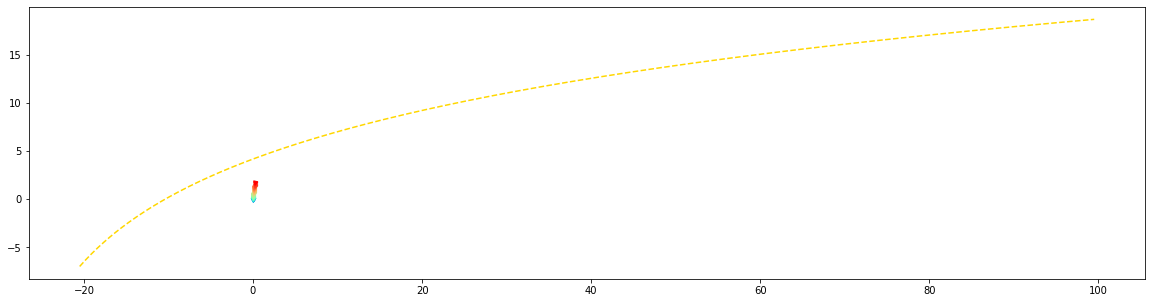


loss = 611497.7152336058




In [46]:
from torch.utils.data import DataLoader

n_steps = 30

n_features = 5
n_layers = 30

hidden_dim = 30
output_size = 4

road = road2
center_line = torch.unsqueeze(torch.tensor(road), dim=0)
desired_velocity = 10 # m/s
timestep = 0.1

cost_fn_weights = [7, 10, 3] # centerLineWeight, velocityWeight, headingWeight

model = PathPlanner(n_steps, n_features, hidden_dim, output_size, n_layers, len(road2))
model = model.double()

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable params in model: {pytorch_total_params}\n')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-100)
loss_fn = PlannerLoss(cost_fn_weights, desired_velocity, timestep)
x, initial_states = buildDataset(1, n_steps, desired_velocity)
x = torch.tensor(x, dtype=torch.double)
initial_states = torch.tensor(initial_states, dtype=torch.double)

print("inital heading", np.squeeze(initial_states)[-1] % 360, '\n')

# # for testing only
# test_trajectory = getUpdatedStates(initial_states.detach().numpy(), generateRandomControls(6))
plot_trajectory(x.detach().numpy()[0][...,:-1], road, verbose=1)
print('\n\n')

epochs = 101
display = 10

for epoch in range(epochs + 1):
    model.train()

    controls_output = model(x, center_line)
    loss = loss_fn(initial_states, controls_output, center_line, verbose=(epoch % display == 0 and epoch != 0))

    if epoch != 0 and epoch % display == 0:
        print_states = getUpdatedStates(initial_states.detach().numpy(), controls_output.detach().numpy(), timestep)
        plot_trajectory(print_states, road, verbose=0)
        print(f'\nloss = {loss}\n\n')

    model.zero_grad()
    loss.backward()
    optimizer.step()

In [39]:
# from torch.utils.data import DataLoader

# batch_size = 10 
# n_workers = 1

# n_steps = 8

# train_dataset = ControlsDataset(buildDataset(100000, n_steps))
# val_dataset = ControlsDataset(buildDataset(20000, n_steps))
# # train_dataset = ControlsDataset(buildDataset(5, n_steps))
# # val_dataset = ControlsDataset(buildDataset(2, n_steps))
# validation_set = DataLoader(val_dataset,
#                             batch_size=batch_size,
#                             shuffle=True,
#                             num_workers=n_workers,
#                            )
# training_set = DataLoader(train_dataset,
#                           batch_size=batch_size,
#                           shuffle=True,
#                           num_workers=n_workers,
#                          )
# dataset = { 'validation': validation_set, 'train': training_set }

In [ ]:
# n_features = 4
# n_layers = 7

# best_path = '/content/drive/My Drive/Research/cc_best.pth'
# chkpt_path = '/content/drive/My Drive/Research/cc_chkpt.pth'

# hidden_dim = n_features
# output_size = n_features

# learning_rate = 1e-2

# log_batch = 1000

# zero_heading = 270 # degrees(°)
# runway_heading = 54.331
# desired_states = (50, runway_heading + zero_heading) # m/s, degrees(°)
# center_line = torch.tensor([2421, -1737], dtype=torch.double)
# cost_fn_weights = [13, 2, 6] # centerLineWeight, velocityWeight, headingWeight

# gpu_exists = torch.cuda.device_count() > 0
# print(f'GPU: {int(gpu_exists)}')

# model = RNN(n_features, hidden_dim, output_size, n_layers, gpu=gpu_exists)
# model = model.double()
# model.load_state_dict(torch.load(chkpt_path))

# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f'Number of trainable params in model: {pytorch_total_params}')

# if gpu_exists:
#     model = model.cuda()
#     center_line = center_line.cuda()

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss_fn = PathLoss(desired_states, center_line, cost_fn_weights, gpu=gpu_exists)

# best_loss = 1e20
# epochs = 100
# for epoch in range(epochs):
#     for phase in ['train', 'validation']:
#         cumu_loss = 0
#         total_loss = 0
#         break_line = '-' * 20
#         print(f'{break_line}\n{phase} at epoch no. {epoch + 1}\n{break_line}')
#         for i, sample in enumerate(dataset[phase]):
#             x, initial_states = sample

#             if gpu_exists:
#                 x = x.cuda()
#                 initial_states = initial_states.cuda()

#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()

#             controls_output = model(x)
#             loss = loss_fn(initial_states, controls_output, verbose=0)

#             cumu_loss += loss
#             total_loss += loss
#             if phase == 'train':
#                 model.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             if i != 0 and i % log_batch == 0:                
#                 print(f'batch {i}: loss = {cumu_loss / log_batch}')
#                 if gpu_exists:
#                     save_model = model.module if torch.cuda.device_count() > 1 else model
#                 else:
#                     save_model = model
#                 torch.save(save_model.state_dict(), chkpt_path)
#                 cumu_loss = 0

#         if phase == 'validation':
#             if total_loss / len(dataset['validation']) < best_loss:
#                 best_loss = total_loss / len(dataset['validation'])
#                 print(f'Loss improved! ({best_loss}) Saving model...')
#                 if gpu_exists:
#                     save_model = model.module if torch.cuda.device_count() > 1 else model
#                 else:
#                     save_model = model
#                 torch.save(save_model.state_dict(), best_path)

#         if gpu_exists:
#             save_model = model.module if torch.cuda.device_count() > 1 else model
#         else:
#             save_model = model
#         torch.save(save_model.state_dict(), chkpt_path)